# Task: Search bing.com for Elon Musk using GPT2-XL

As the first benchmark test we want the model to be able to open a website and search for an entry. This is also a simple introduction to the code.

In this notebook I use the GPT2 model and how we can use that for solving this task.

In [1]:
import os
import numpy as np
from igym import InternetEnv, DefaultActions
import torch
import requests
import json
import matplotlib.pyplot as plt
%matplotlib inline
import random

from transformers import AutoModelForCausalLM, AutoTokenizer

In [2]:
# --- helper functions
def set_seed(seed):
  if seed is not None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [3]:
# user can define the target and AI has to reach the target
QUESTION = "Search bing.com for Elon Musk"

In [4]:
# initialise the model
model = AutoModelForCausalLM.from_pretrained("gpt2-xl")
tok = AutoTokenizer.from_pretrained("gpt2-xl")
tok.pad_token = tok.eos_token

In [5]:
print("Number of Actions:", len(DefaultActions))
act = np.random.choice(DefaultActions)
print("Randomly chosen action:", act)
print("Arguments to be filled for this action:", set(act.args.keys()))

Number of Actions: 3
Randomly chosen action: <igym.Action.OpenLink: 'Open the following URL: None'>
Arguments to be filled for this action: {'url'}


### Step 1: Identify intent using Sequence generation

We will use weighted sequence generation for understanding different parts of the sequence.

In [6]:
@torch.no_grad()
def gpt_completion(sentence, n_steps):
  set_seed(4)
  data = tok([sentence], padding = "longest", return_tensors="pt")
  _len = data["input_ids"].size(-1)
  beam_outputs = model.generate(
    **data,
    max_length = _len + n_steps,
    do_sample = True,
    early_stopping = True,
    temperature = 0.9,
    # num_beams=10,
    top_k = 40,
    top_p = 0.95,
    num_return_sequences=5
  )
  return tok.batch_decode(beam_outputs)

In [7]:
prompt = '''identify the website in the questions:
in -> latest test score results on wikipedia; out -> wikipedia.org
in -> {}; out ->'''.format(QUESTION)
print(prompt)

identify the website in the questions:
in -> latest test score results on wikipedia; out -> wikipedia.org
in -> Search bing.com for Elon Musk; out ->


In [8]:
weights = {}
for x in gpt_completion(prompt, 4):
  last_line = x.split("\n")[len(prompt.split("\n")) - 1]
  print(last_line)
  print('-'*70)
  
  key = last_line.split("->")[-1].strip().lower()
  weights.setdefault(key, 0)
  weights[key] += 1
  
print(weights)

in -> Search bing.com for Elon Musk; out -> bing.com
----------------------------------------------------------------------
in -> Search bing.com for Elon Musk; out -> wikipedia.org
----------------------------------------------------------------------
in -> Search bing.com for Elon Musk; out -> Google.com
----------------------------------------------------------------------
in -> Search bing.com for Elon Musk; out -> bing.com
----------------------------------------------------------------------
in -> Search bing.com for Elon Musk; out -> bing.com
----------------------------------------------------------------------
in -> Search bing.com for Elon Musk; out -> Search bing.
----------------------------------------------------------------------
in -> Search bing.com for Elon Musk; out -> www.elon
----------------------------------------------------------------------
in -> Search bing.com for Elon Musk; out -> Elon Musk's Twitter
---------------------------------------------------------

So you can see from sampling, `bing.com` came as the highest scored item link. Similarly we can extract for the words "Elon Musk".

In [9]:
prompt = '''identify the item to be searched:
in -> wikipedia entry for Tennis; out -> Tennis
in -> {}; out ->'''.format(QUESTION)
print(prompt)

identify the item to be searched:
in -> wikipedia entry for Tennis; out -> Tennis
in -> Search bing.com for Elon Musk; out ->


In [10]:
weights = {}
for x in gpt_completion(prompt, 4):
  last_line = x.split("\n")[len(prompt.split("\n")) - 1]
  print(last_line)
  print('-'*70)
  
  key = last_line.split("->")[-1].strip()
  weights.setdefault(key, 0)
  weights[key] += 1
  
print(weights)

in -> Search bing.com for Elon Musk; out -> Elon Musk
----------------------------------------------------------------------
in -> Search bing.com for Elon Musk; out -> Elon Musk
----------------------------------------------------------------------
in -> Search bing.com for Elon Musk; out -> Search bing.
----------------------------------------------------------------------
in -> Search bing.com for Elon Musk; out -> Google
----------------------------------------------------------------------
in -> Search bing.com for Elon Musk; out -> bing.com
----------------------------------------------------------------------
in -> Search bing.com for Elon Musk; out -> Search bing.
----------------------------------------------------------------------
in -> Search bing.com for Elon Musk; out -> Search google.com
----------------------------------------------------------------------
in -> Search bing.com for Elon Musk; out -> Elon Musk
-------------------------------------------------------------

In [11]:
# I am skipping a few steps here:
# - cleaning up the URL (easy)
# - creating a unified dictionary
# code for both these operations can be written easily

args_dict = {
  "url": "https://www.bing.com",
  "text": "Elon Musk"
}

### Step 2: Action selection by Comparing Embeddings

Once we have the args from Step 1 we will find the correct actions.

In [12]:
def tokenize(texts):
  texts = [x + tok.eos_token for x in texts]
  data = tok(texts, padding = "longest", return_tensors="pt")
  eot_ = data["input_ids"].argmax(1)
  return texts, data, eot_

In [13]:
texts_actions, data_actions, eot_actions = tokenize([x.text for x in DefaultActions])
data_actions["input_ids"].size(), eot_actions, data_actions["input_ids"][torch.arange(len(eot_actions)),  eot_actions]

(torch.Size([3, 16]), tensor([ 8, 12, 15]), tensor([50256, 50256, 50256]))

In [14]:
with torch.no_grad():
  output = model(**data_actions, output_hidden_states = True)
  
# this is 13 for embeddings and rest of blocks
len(output.hidden_states), output.hidden_states[-1].size() 

(13, torch.Size([3, 16, 768]))

In [15]:
eot_log_actions = output.hidden_states[-1][torch.arange(len(eot_actions)),  eot_actions]
eot_log_actions = eot_log_actions / eot_log_actions.norm(dim = -1, keepdim=True)
eot_log_actions

tensor([[ 5.7802e-04, -6.4203e-04,  6.6119e-04,  ...,  5.5200e-04,
         -4.6297e-04,  1.6015e-04],
        [ 4.5838e-04, -6.6664e-04,  5.4130e-04,  ...,  4.2890e-04,
         -5.7347e-04,  8.8789e-05],
        [ 4.1396e-04, -7.0390e-04,  5.5007e-04,  ...,  4.5121e-04,
         -5.5329e-04,  1.4181e-04]])

In [16]:
actions_inter = eot_log_actions @ eot_log_actions.T
actions_inter = actions_inter.softmax(-1)

In [17]:
actions_inter.numpy()

array([[0.3333649 , 0.33331427, 0.33332083],
       [0.33330002, 0.33335042, 0.33334956],
       [0.33330438, 0.33334732, 0.33334827]], dtype=float32)

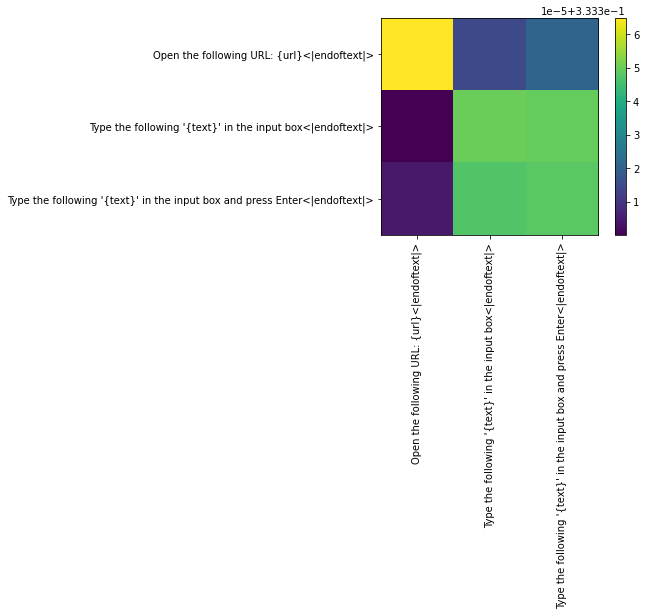

In [18]:
plt.xticks(range(len(actions_inter)), texts_actions, rotation = 90)
plt.yticks(range(len(actions_inter)), texts_actions, rotation = 0)
plt.imshow(actions_inter.numpy())
plt.colorbar()

In [19]:
query_texts = ["To Open the following URL 'www.bing.com'"]
query_texts, data_query, eot_query = tokenize(query_texts)
data_query["input_ids"].size(), eot_query, data_query["input_ids"][torch.arange(len(eot_query)), eot_query]

(torch.Size([1, 13]), tensor([12]), tensor([50256]))

In [20]:
with torch.no_grad():
  output = model(**data_query, output_hidden_states = True)
eot_log_query = output.hidden_states[-1][torch.arange(len(eot_query)), eot_query]
eot_log_query = eot_log_query / eot_log_query.norm(-1, keepdim=True)

In [21]:
qd = (eot_log_query @ eot_log_actions.T).softmax(-1)

In [22]:
qd.numpy()

array([[1., 0., 0.]], dtype=float32)

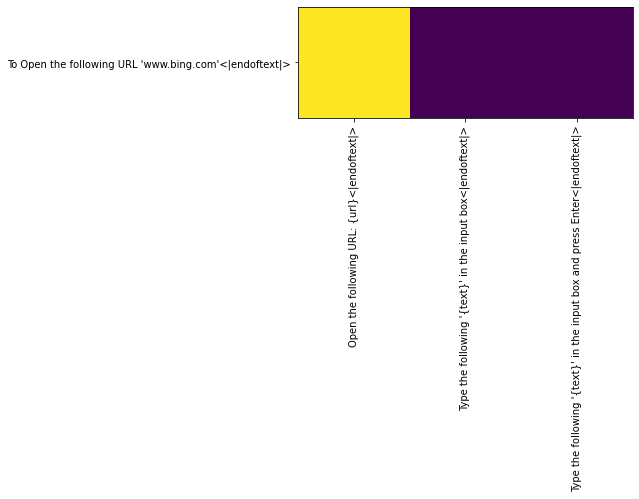

In [23]:
plt.xticks(range(len(actions_inter)), texts_actions, rotation = 90)
plt.yticks(range(len(eot_log_query)), query_texts, rotation = 0)
plt.imshow(qd.numpy())

Thus you can see that filling the template for URL gives a high similarity to action 0.

In [24]:
act0 = DefaultActions[0]
act0.fill_values(url = args_dict["url"])
act0

<igym.Action.OpenLink: 'Open the following URL: https://www.bing.com'>

In [25]:
query_texts = ["To search for value 'Elon Musk' by typing in a box"]
query_texts, data_query, eot_query = tokenize(query_texts)
data_query["input_ids"].size(), eot_query, data_query["input_ids"][torch.arange(len(eot_query)), eot_query]

(torch.Size([1, 15]), tensor([14]), tensor([50256]))

In [26]:
with torch.no_grad():
  output = model(**data_query, output_hidden_states = True)
eot_log_query = output.hidden_states[-1][torch.arange(len(eot_query)), eot_query]
eot_log_query = eot_log_query / eot_log_query.norm(-1, keepdim=True)
qd = (eot_log_query @ eot_log_actions.T).softmax(-1)

In [27]:
qd.numpy()

array([[0.000e+00, 5.521e-42, 1.000e+00]], dtype=float32)

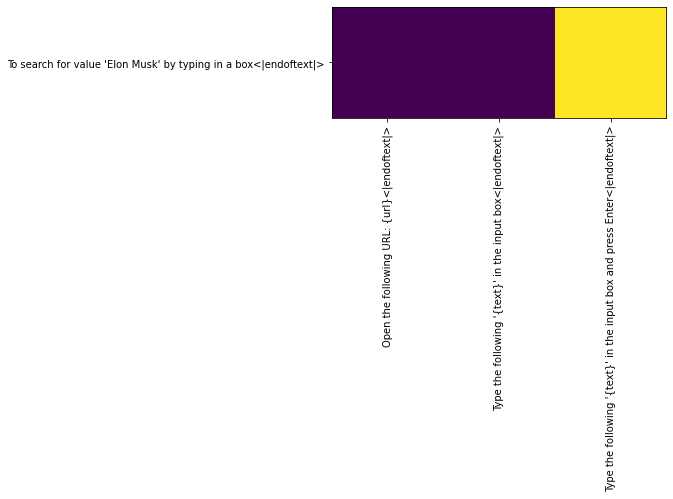

In [28]:
plt.xticks(range(len(actions_inter)), texts_actions, rotation = 90)
plt.yticks(range(len(eot_log_query)), query_texts, rotation = 0)
plt.imshow(qd.numpy())

Similarly you get action 2 as second step.

In [29]:
act1 = DefaultActions[2]
act1.fill_values(text = args_dict["text"])
act1

<igym.Action.TypeInputAndPressEnter: 'Type the following 'Elon Musk' in the input box and press Enter'>

In [30]:
# combine the actions since we can pass the chain of arguments
actions = [act0, act1]
actions

[<igym.Action.OpenLink: 'Open the following URL: https://www.bing.com'>,
 <igym.Action.TypeInputAndPressEnter: 'Type the following 'Elon Musk' in the input box and press Enter'>]

In [31]:
# initialise the environment with chromedriver
# in this example I have the chromedriver in the same folder as this notebook
env = InternetEnv("./chromedriver")

In [32]:
# user can pass a single action or list of actions
# env.step(open_link)
env.step(actions_list = actions)

In [33]:
# after you are done checking the outcome
env.close()